In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay  # error

filepath = Path.cwd()
print(filepath)

/vol/ml/apartin/projects/DrugResponseViz/notebooks


In [2]:
cancer_types = pd.read_csv(filepath/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])

In [3]:
#df = pd.read_parquet(filepath/'../data/top_21.res_reg.cf_rnaseq.dd_dragon7.labled.rvNone.parquet')
df = df[['SOURCE', 'CELL', 'DRUG', 'AUC', 'R2fit']]

df['y_true_cls'] = [0 if v>0.5 else 1 for v in df['AUC'].values]
df = df.reset_index().rename(columns={'index': 'idx'})
print(df.shape)

(371657, 7)


0.0001


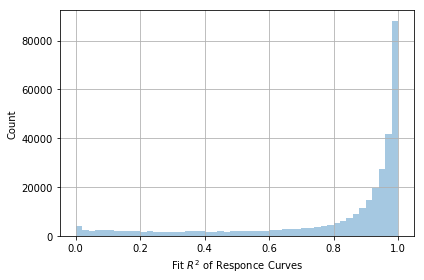

In [8]:
th = 0
print(df.R2fit[df.R2fit>th].min())
ax = sns.distplot(df.R2fit[df.R2fit>th], bins=50, kde=False);
# ax.set_title(r'Histogram of $R^2$ Fit values (for R2>0)')
ax.set_ylabel('Count');
ax.set_xlabel(r'Fit $R^2$ of Responce Curves');
ax.grid(True)

plt.tight_layout()
plt.savefig('F2fit_hist.png', dpi=150)

In [9]:
# Bin R2fit values
bins_ = np.arange(0, 1.1, 0.1).tolist()
bins = [-np.Inf]
bins.extend(bins_)
df['R2_Fit_bin'] = pd.cut(df.R2fit, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise')
# df['R2_Fit_bin'] = df['R2_Fit_bin'].astype(str)

In [10]:
# for c in df['R2_Fit_bin'].cat.categories:
#     aa = df[df['R2_Fit_bin']==c]
#     print(c, aa.shape[0])

In [11]:
# aa = df.groupby(['R2_Fit_bin', 'AUC_cls']).agg({'idx': len}).reset_index()
aa = df.groupby(['R2_Fit_bin', 'y_true_cls']).agg({'idx': len}).reset_index()
aa = pd.pivot_table(aa, values='idx', index='R2_Fit_bin', columns='y_true_cls')
aa.columns.name = None
aa = aa.reset_index()
aa = aa.rename(columns={0: 'no_rsp', 1: 'rsp'})
aa['tot'] = aa.no_rsp + aa.rsp
aa['rsp_ratio'] = aa.rsp/(aa.rsp + aa.no_rsp)
bin_cnt = aa

,R2_Fit_bin,no_rsp,rsp,tot,rsp_ratio
0,"(-inf, 0.0]",46000,288,46288,0.006222
1,"(0.0, 0.1]",13193,152,13345,0.011390
2,"(0.1, 0.2]",10866,123,10989,0.011193
3,"(0.2, 0.3]",9031,148,9179,0.016124
4,"(0.3, 0.4]",9445,219,9664,0.022661
5,"(0.4, 0.5]",8741,279,9020,0.030931
6,"(0.5, 0.6]",10099,314,10413,0.030155
7,"(0.6, 0.7]",12843,403,13246,0.030424
8,"(0.7, 0.8]",18347,653,19000,0.034368
9,"(0.8, 0.9]",37393,1490,38883,0.038320


In [12]:
tot = bin_cnt['tot'].values.sum()
prc = []
for i in range(bin_cnt.shape[0]):
    prc.append( sum(bin_cnt.loc[:i, 'tot'].values)/tot )  # cummulative percent
bin_cnt['cum_prcnt'] = prc
display(bin_cnt)

,R2_Fit_bin,no_rsp,rsp,tot,rsp_ratio,cum_prcnt
0,"(-inf, 0.0]",46000,288,46288,0.006222,0.124545
1,"(0.0, 0.1]",13193,152,13345,0.011390,0.160452
2,"(0.1, 0.2]",10866,123,10989,0.011193,0.190019
3,"(0.2, 0.3]",9031,148,9179,0.016124,0.214717
4,"(0.3, 0.4]",9445,219,9664,0.022661,0.240719
5,"(0.4, 0.5]",8741,279,9020,0.030931,0.264989
6,"(0.5, 0.6]",10099,314,10413,0.030155,0.293007
7,"(0.6, 0.7]",12843,403,13246,0.030424,0.328647
8,"(0.7, 0.8]",18347,653,19000,0.034368,0.379770
9,"(0.8, 0.9]",37393,1490,38883,0.038320,0.484390


In [14]:
# df.groupby(['R2_Fit_bin', 'SOURCE']).agg({'idx': len}).reset_index()[:5]

In [29]:
def my_barplot(labels, values, ylabel=None, xlabel=None, color='b', text_on_plot=True, figsize=(7,5)):
    """ Simple barplot. """
    labels = labels
    values = values
    fig, ax = plt.subplots(figsize=figsize)
    rects = ax.barh(labels, values,
                    align='center', height=0.7,
                    color=color, edgecolor='k', alpha=0.6)

    pos = np.arange(len(labels))
    ylabels = [' '.join(s.split('_')) for s in labels]
    ax.set_yticks( pos )
    ax.set_yticklabels( ylabels )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if text_on_plot:
        for rect in rects:
            width = rect.get_width()
            width = np.around(width, decimals=2)
            align = 'left'

            xloc = -40
            yloc = rect.get_y() + rect.get_height() / 2  # Center the text vertically in the bar
            label = ax.annotate(width,
                                xy=(width, yloc),
                                xytext=(xloc, 0),           # The position (x,y) to place the text at. If None, defaults to xy.
                                textcoords='offset points', # The coordinate system that xytext is given in
                                ha=align, va='center',
                                color='k', weight='bold', clip_on=True);
    return fig, ax

In [18]:
bin_cnt

,R2_Fit_bin,no_rsp,rsp,tot,rsp_ratio,cum_prcnt
0,"(-inf, 0.0]",46000,288,46288,0.006222,0.124545
1,"(0.0, 0.1]",13193,152,13345,0.011390,0.160452
2,"(0.1, 0.2]",10866,123,10989,0.011193,0.190019
3,"(0.2, 0.3]",9031,148,9179,0.016124,0.214717
4,"(0.3, 0.4]",9445,219,9664,0.022661,0.240719
5,"(0.4, 0.5]",8741,279,9020,0.030931,0.264989
6,"(0.5, 0.6]",10099,314,10413,0.030155,0.293007
7,"(0.6, 0.7]",12843,403,13246,0.030424,0.328647
8,"(0.7, 0.8]",18347,653,19000,0.034368,0.379770
9,"(0.8, 0.9]",37393,1490,38883,0.038320,0.484390


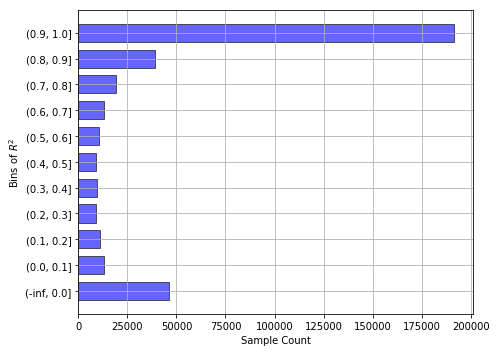

In [34]:
labels = [str(x) for x in bin_cnt['R2_Fit_bin'].values]
fig, ax = my_barplot(labels=labels,
                     values=bin_cnt['tot'].values,
                     xlabel='Sample Count',
                     ylabel=r'Bins of $R^2$',
                     color='b', text_on_plot=False, figsize=(7,5));
ax.grid(True)
ax.set_xticklabels(rotation=45);

plt.tight_layout()
plt.savefig('R2fit_bins_barplot.png', dpi=150)

In [35]:
# g = sns.catplot(data=df, y='R2_Fit_bin', kind='count');
# g.set_xticklabels(rotation=45);

# Analyze the effect ot R2 Fit

In [36]:
path = Path(filepath/'../rv_trains')
trn_rv_dirs = [Path(d) for d in glob(str(path/'trn_rv0.*'))]

In [38]:
# Combine results
te_scr = []
for p in trn_rv_dirs:
    dd = pd.read_csv( p/'te_scores.csv' )
    dd.insert( loc=0, column='rv', value=str(p).split('/')[-1].split('_rv')[-1] )
    te_scr.append(dd)
    
te_scr = pd.concat(te_scr, axis=0)

# Agg results
te_scr['mcc_median'] = te_scr['mcc']
te_scr['mcc_std'] = te_scr['mcc']
te_scr['brier_median'] = te_scr['brier']
te_scr['brier_std'] = te_scr['brier']
te_scr['f1_median'] = te_scr['f1_score']
te_scr['f1_std'] = te_scr['f1_score']

te_scr = te_scr.groupby(['rv']).agg(
    {'mcc_median': 'median',   'mcc_std': 'std',
     'brier_median': 'median', 'brier_std': 'std',
     'f1_median': 'median',   'f1_std': 'std'}).reset_index()

display( te_scr )

,rv,mcc_median,mcc_std,brier_median,brier_std,f1_median,f1_std
0,0.0,0.601335,0.012717,0.019008,0.000504,0.973964,0.000853
1,0.1,0.604802,0.011972,0.019516,0.000562,0.973337,0.000903
2,0.2,0.606922,0.013273,0.020059,0.000567,0.972504,0.000919
3,0.3,0.604798,0.011490,0.020365,0.000549,0.972049,0.000920
4,0.4,0.607332,0.012055,0.020731,0.000599,0.971641,0.001045
5,0.5,0.605238,0.012092,0.021004,0.000601,0.971351,0.001118
6,0.6,0.609091,0.013197,0.021289,0.000646,0.970850,0.001057
7,0.7,0.610998,0.011388,0.021495,0.000564,0.970515,0.000949
8,0.8,0.621787,0.012909,0.021555,0.000622,0.970406,0.000962
9,0.9,0.630671,0.013222,0.022036,0.000707,0.969745,0.001158


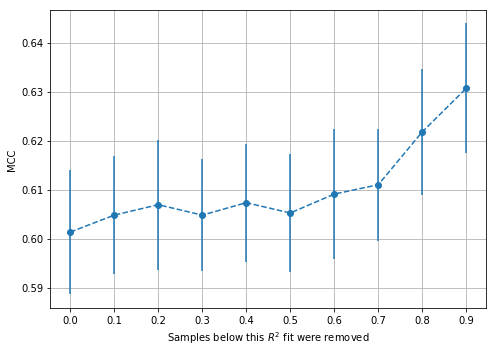

In [47]:
_, ax = plt.subplots(1, 1, figsize=(7,5))

ax.errorbar(te_scr['rv'], te_scr['mcc_median'], yerr=te_scr['mcc_std'], ls='--', marker='o', label='MCC');
ax.set_ylabel('MCC')
ax.set_xlabel(r'Samples below this $R^2$ fit were removed');
ax.grid(True)

plt.tight_layout()
plt.savefig('MCC_vs_R2fit.png', dpi=150)

In [1]:
# _, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True)
# ax = ax.ravel()

# ax[0].errorbar(te_scr.rv, te_scr.mcc_median, yerr=te_scr.mcc_std, label='MCC');
# ax[0].set_ylabel('MCC')
# ax[1].errorbar(te_scr.rv, te_scr.brier_median, yerr=te_scr.brier_std, label='Brier');
# ax[1].set_ylabel('Brier')
# ax[2].errorbar(te_scr.rv, te_scr.f1_median, yerr=te_scr.f1_std, label='F1');
# ax[2].set_ylabel('F1')
# ax[2].set_xlabel('Samples below this R2 Fit  value were removed');